# Linear Prediction with Block Adaptation

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Block adaptation using the auto-correlation method
* Spectrum of analysis and synthesis filters
* Auto-correlation of the speech signal and prediction error

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
from scipy.signal import lfilter
from scipy.io import wavfile
import IPython.display as ipd
import shutil

Consider two different wave files

In [2]:
def audio_load(filename, sr = None):
    old_sampling_rate, x = wavfile.read(filename)
    if len(x.shape) == 2:
        x = np.squeeze(x[:,0])
    x = x/32768
    if sr is not None:
        sampling_rate = sr
        number_of_samples = round(len(x) * sampling_rate / old_sampling_rate) 
        x = sp.resample(x, number_of_samples)
    else:
        sampling_rate = old_sampling_rate
    return x, sampling_rate

In [3]:
def audio_display_waveshow(y, sr, alpha = 0.8, color = 'skyblue', linewidth = 1):
    time = np.linspace(0, len(y) / sr, num=len(y))
    #plt.plot(time, y, color=color, alpha=alpha, linewidth=1)
    #plt.xlim(time[0], time[-1])
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.fill_between(time, -np.abs(y), np.abs(y), color='skyblue')
    plt.xlabel("Time")


In [4]:
wave_filename = 'speech_segment.wav'

# load file, do *not* resample
x, sampling_rate= audio_load(wave_filename)



print(len(x))
# only use the first 1120 samples (140 ms)
x = x[:640]


# time in ms
t = np.arange(len(x)) / sampling_rate * 1000.0

660


In [5]:
# helper function calculating the auto-correlation coefficient r
def get_r(x, l):    
    x_shift = np.roll(x,l)
    x_shift[:l] = 0        
    return np.correlate(x,x_shift)[0]
    
    
def get_prediction_coefficients(x, n):
    r = np.array([get_r(x,k) for k in np.arange(1,n+1)])
    R = np.array([np.concatenate(([get_r(x,j) for j in np.arange(i,0,-1)], [get_r(x,j) for j in np.arange(0,n-i)])) for i in range(n)])    
    
    a_opt = np.linalg.inv(R) @ r
    return a_opt

def get_prediction_frequency_response(a, Omega):    
    A = np.ones_like(Omega) + 1j*np.zeros_like(Omega)
    for k in range(len(a)):
        A -= a[k] * np.exp(-1j*(k+1)*Omega)
    return A

In [6]:
# block-wise processing

#prediction_order 
n = 8

# N samples per frame, here N = 160, with sampling rate of 8 Khz, we have 20 ms frames
N = 160 
frames = int(np.floor(len(x) / N))

d = np.zeros_like(x)

# no adaptation for first frame
a = np.zeros(n)

# filter memory
memory = np.zeros(n)

a_save = []
for k0 in range(frames):
    
    x_part = x[np.arange(N)+k0*N]

    xh_part, memory = lfilter(np.concatenate(([0], a)), 1, x_part, zi=memory)
    d[np.arange(len(xh_part)) + k0*N] = x[np.arange(len(xh_part)) + k0*N] - xh_part

    # update filter coefficients and save filter coefficients for plotting
    a = get_prediction_coefficients(x_part, n)
    a_save.append(a)
    

X = np.fft.fft(x)
D = np.fft.fft(d)

# circular frequencies
Omega = np.linspace(0,np.pi,512)

A = [get_prediction_frequency_response(a_save[k0], Omega) for k0 in range(len(a_save))]

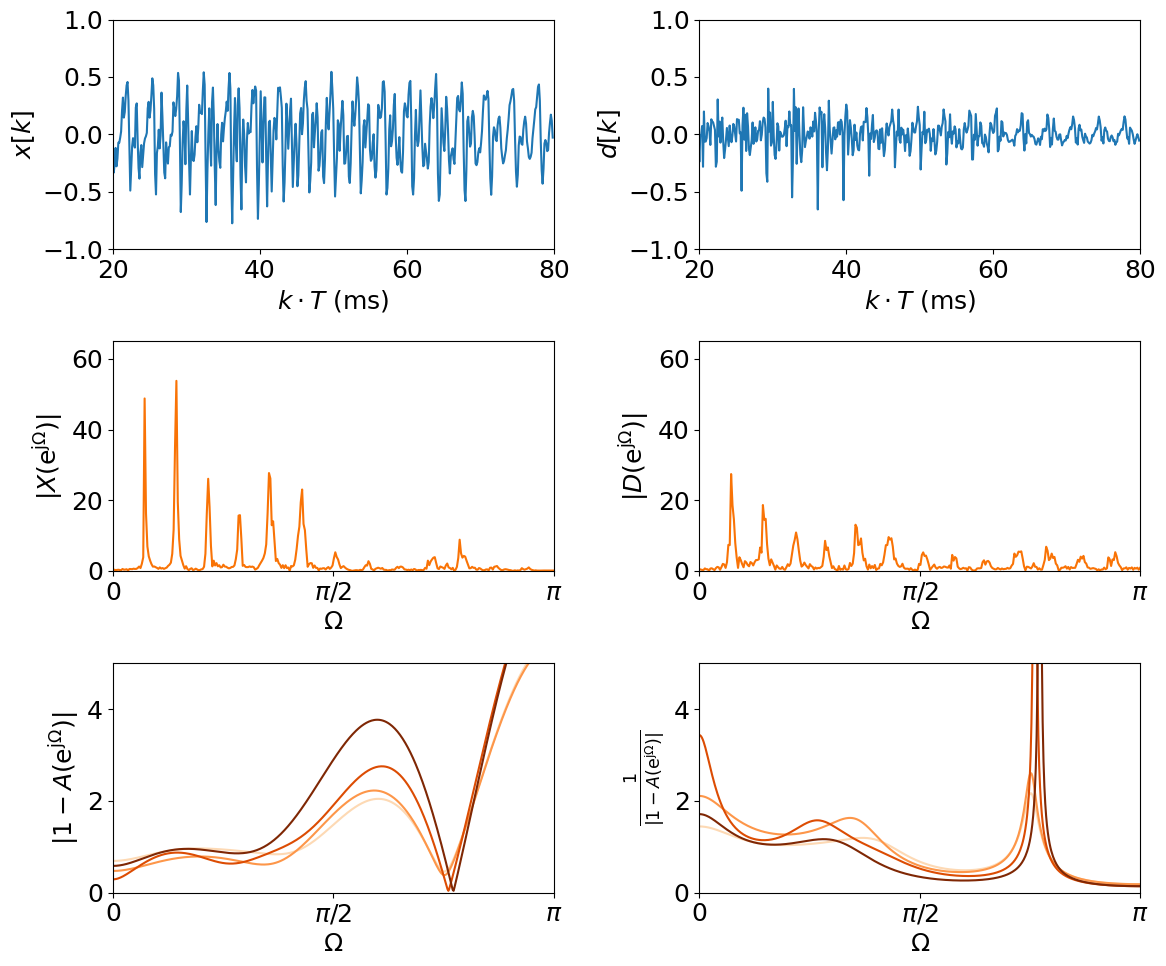

In [7]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(12, 10))
plt.subplot(3,2,1)
plt.plot(t, x)
plt.xlim((20,80))
plt.ylim((-1,1))
plt.xlabel('$k\cdot T$ (ms)')
plt.ylabel('$x[k]$')

plt.subplot(3,2,2)
plt.plot(t,d[:len(t)])
plt.xlim((20,80))
plt.ylim((-1,1))
plt.xlabel('$k\cdot T$ (ms)')
plt.ylabel('$d[k]$')

plt.subplot(3,2,3)
plt.plot(np.linspace(0,np.pi,len(X)//2),np.abs(X[:(len(X)//2)]), color='xkcd:orange')
plt.xlim((0,np.pi))
plt.ylim((0,65))
plt.xticks([0,np.pi/2,np.pi],labels=['0', '$\pi/2$', '$\pi$'])
plt.xlabel('$\Omega$')
plt.ylabel('$|X(\mathrm{e}^{\mathrm{j}\Omega})|$')

plt.subplot(3,2,4)
plt.plot(np.linspace(0,np.pi,len(D)//2),np.abs(D[:(len(D)//2)]), color='xkcd:orange')
plt.xlim((0,np.pi))
plt.ylim((0,65))
plt.xticks([0,np.pi/2,np.pi],labels=['0', '$\pi/2$', '$\pi$'])
plt.xlabel('$\Omega$')
plt.ylabel('$|D(\mathrm{e}^{\mathrm{j}\Omega})|$')


plt.subplot(3,2,5)
color_idx = np.linspace(0.2, 1, len(A))
for i,k0 in zip(color_idx, range(len(A))):
    plt.plot(Omega,np.abs(1-A[k0]), c=plt.cm.Oranges(i))
plt.xlim((0,np.pi))
plt.ylim((0,5))
plt.xticks([0,np.pi/2,np.pi],labels=['0', '$\pi/2$', '$\pi$'])
plt.xlabel('$\Omega$')
plt.ylabel('$|1-A(\mathrm{e}^{\mathrm{j}\Omega})|$')


plt.subplot(3,2,6)
color_idx = np.linspace(0.2, 1, len(A))
for i,k0 in zip(color_idx, range(len(A))):
    plt.plot(Omega,1/np.abs(1-A[k0]), c=plt.cm.Oranges(i))
plt.xlim((0,np.pi))
plt.ylim((0,5))
plt.xticks([0,np.pi/2,np.pi],labels=['0', '$\pi/2$', '$\pi$'])
plt.xlabel('$\Omega$')
plt.ylabel(r'$\frac{1}{|1-A(\mathrm{e}^{\mathrm{j}\Omega})|}$')

plt.tight_layout()
#plt.savefig('figure_DST_6.10.pdf', bbox_inches='tight')

---
Plot the correlation of $x[k]$ and $d[k]$ to show long-term effects

In [8]:
phi_XX = [get_r(x,l) for l in range(160)]
phi_DD = [get_r(d,l) for l in range(160)]

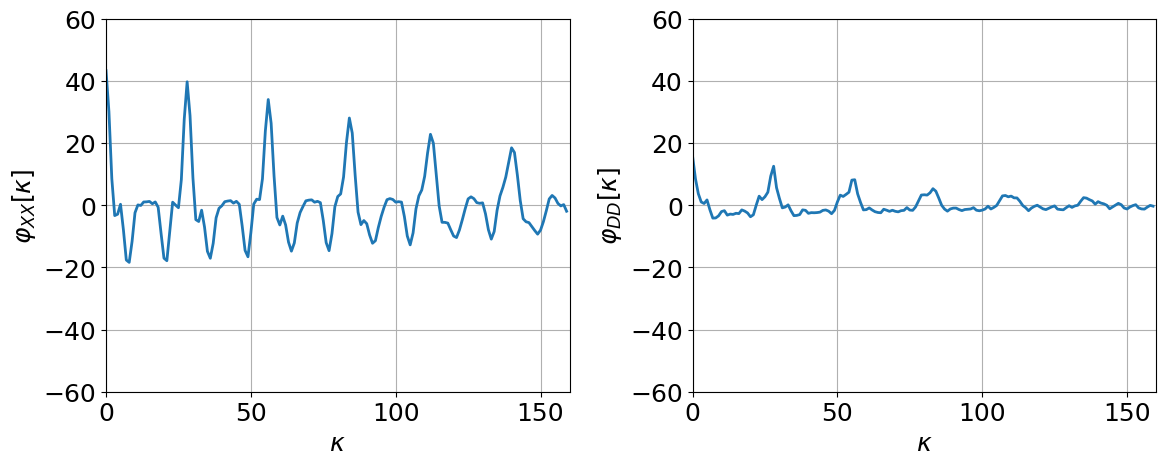

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(range(160), phi_XX, lw=2)
plt.xlim((0,160))
plt.ylim((-60,60))
plt.xlabel('$\kappa$')
plt.ylabel(r'$\varphi_{XX}[\kappa]$')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(160), phi_DD, lw=2)
plt.xlim((0,160))
plt.ylim((-60,60))
plt.xlabel('$\kappa$')
plt.ylabel(r'$\varphi_{DD}[\kappa]$')
plt.grid(True)

plt.tight_layout()
#plt.savefig('figure_DST_6.14.pdf', bbox_inches='tight')